# Fouille de données / Data Mining
## Fouille de réseaux sociaux / Mining of social networks



## Réseaux sociaux / Social Networks
Les réseaux sociaux occupent une grande partie de la vie humaine. Chaque personne appartient tout le long de sa vie à différentes communautés. Avec le rassemblage de ces informations sur les différentes plateformes en ligne de réseaux sociaux, les analystes de données ont voulu exploiter ces données. C'est un domaine relativement nouveau qui est en pleine croissance avec plusieurs impacts sur plusieurs aspects tels que la publicité et les systèmes de recommandation.

### But
Le but est de démontrer un aperçu de l'analyse d'un réseau social.

Dans la première partie, nous implémenterons un algorithme de détection de communautés dans un réseau social nommé LPAm+. Cet algorithme a été proposé par [X. Liu et T. Murata en 2010](https://www.sciencedirect.com/science/article/pii/S0378437109010152).

Dans la deuxième partie, nous trouverons les personnes avec le plus d'influence dans leur réseau social.

Pour les deux parties, nous utiliserons les CSV contenant les réseaux sociaux à analyser.


---

## Social networks
Social networks are a major component of the human life. Each person belongs throughout their life to different communities. With the aggregation of information on various online social media platforms, data analysts were interested in exploiting its data. It is a relatively new field that is growing with impacts on several aspects such as advertising and recommendation systems.


### Goal
The goal is to show an overview of social network analysis.

In the first part, we will implement an algorithm for detecting communities in a social network called LPAm+. This algorithm was proposed by [X. Liu and T. Murata in 2010](https://www.sciencedirect.com/science/article/pii/S0378437109010152).

In the second part, we will find the people with the most influence in their social network.

For both parts, we will use the CSV containing the social networks to be analysed.

# 1. LPAm+

## Détection de communauté
La détection de communauté dans un réseau social est une manipulation fréquente lors de l'analyse d'un réseau. Une méthode de clustering est utilisée pour rassembler les personnes dans des communautés selon les liens entre eux.

## LPAm+
Dans cette partie, nous implémenterons l'algorithme LPAm+ pour détecter les communautés parmi les personnages de Games of Thrones. Nous utiliserons les CSV *nodes* et *edges* pour cela.

Cet algorithme consiste à propager les étiquettes dans le réseau selon une règle d'évaluation optimisant la modularité du réseau. Lorsque l'algorithme atteint un optimum local, il regarde s'il peut combiner deux communautés pour augmenter la modularité du réseau. L'algorithme choisit toujours la combinaison la plus avantageuse. Si une combinaison est trouvée, la propagation des étiquettes est refaite. L'algorithme continue tant qu'elle peut améliorer la modularité. Nous pouvons lire l'article mentionné plus haut pour plus de détails.

Pour faciliter la représentation du réseau, nous utiliserons le package networkx. La documentation est disponible [ici](https://networkx.github.io/documentation/stable/tutorial.html).



---

# 1. LPAm+


## Community detection
Community detection in a social network is a frequent manipulation when analysing a network. A clustering method is used to bring people together in communities according to the links between them.


## LPAm+
In this part, we will implement the LPAm+ algorithm to detect the communities among the characters of Games of Thrones. We will use the nodes and edges csv for this.

This algorithm consists in propagating the labels in the network according to an evaluation rule optimizing the modularity of the network. When the algorithm reaches a local optimum, it checks whether it can combine two communities to increase the modularity of the network. The algorithm always chooses the most advantageous combination. If a combination is found, the propagation of the labels is redone. The algorithm continues until it is no longer able to increase modularity. We can read the article mentioned above for more details.


To represent a network, we will use the networkx package.The documentation can be found [here](https://networkx.github.io/documentation/stable/tutorial.html).

In [1]:

import numpy as np
import networkx as nx
import random
import itertools
import math


class LPAmPlus:

    def __init__(self, graph):
        """
        graph gives the graph on which the algorithm will be applied;
        """
        self.graph = graph

        # Initialise "labels": Each nodes must be in their own community.
        for id in self.graph.nodes:
            self.graph.nodes[id]["label"] = id

        # labels: all the communities present in the network
        self.labels = [self.graph.nodes[i]["label"] for i in self.graph.nodes]

        self.N = nx.number_of_nodes(self.graph)
        self.node_lst = list(self.graph.nodes)


    def label_evaluation(self, current_node, new_label):
        """
        Term to optimize when updating labels
        return the value for the term to optimize, which is the sum in the argmax formular for a given label
        """

        Bl = nx.linalg.modularity_matrix(self.graph)

        for u in range(self.N):
            if current_node != u:
                delta = 1 if self.graph.nodes[self.node_lst[u]]['label'] == new_label else 0
                Bl[u, current_node] = Bl[u, current_node] * delta

        return np.sum(Bl)


    def update_label(self, current_node):
        """
        Choose a new label for a node, after calling label_evaluation to decide the most frequent label among its neighbors
        """

        d = {}
        for l in set(self.labels):
            d[l] = self.label_evaluation(current_node, l)

        newlabel = max(d, key=lambda key: d[key])

        # change the node's label
        self.graph.nodes[self.node_lst[current_node]]['label'] = newlabel

        return newlabel


    def modularity(self):
        """
        calculates the current modularity of the network
        """

        Bm = nx.linalg.modularity_matrix(self.graph)
        # N = nx.number_of_nodes(self.graph)
        M = nx.number_of_edges(self.graph)
        # Bm = self.B.copy()

        for i in range(self.N):
            for j in range(self.N):
                delta = 1 if self.graph.nodes[self.node_lst[i]]['label'] == self.graph.nodes[self.node_lst[j]]['label'] else 0
                Bm[i, j] = Bm[i, j] * delta

        Q = np.sum(Bm) / (2 * M)

        return Q


    def LPAm(self):
        """
        applies the LPAm algorithm on the network
        """

        Q0 = self.modularity()
        # print("inside lpma Q0: ", Q0)
        while True:
            for x in range(self.N):
                newlabel = self.update_label(x)
                # print("inside lpma: ", self.labels)
                self.labels[x] = newlabel
            Q = self.modularity()
            # print("Q: ", Q)
            if (Q <= Q0):
              return 0
            else:
                Q0 = Q


    def merge_communities(self):
        """
        find the communities to combine and combine them
        """

        Q0 = self.modularity()
        merged = False
        community_pairs = list(itertools.combinations(set(self.labels), 2))

        # for each community pair (t1, t2), merge communities t1 and t2
        for pair in community_pairs:
            modified_nodes = []
            for i in range(self.N):
                if self.graph.nodes[self.node_lst[i]]["label"] == pair[0]:
                    modified_nodes.append(i)
                    self.graph.nodes[self.node_lst[i]]["label"] = pair[1]
            Q = self.modularity()
            if (Q <= Q0):
                for i in modified_nodes:
                    self.graph.nodes[self.node_lst[i]]["label"] = pair[0]
            else:
                Q0 = Q
                merged = True

        return merged


    def find_communities(self):
        """
        applies the LPAm+ algorithm on the network
        """
        self.LPAm()
        while self.merge_communities():
            self.labels = [self.graph.nodes[i]["label"] for i in self.graph.nodes]



### 1.1 Dataset

Les données pour toutes les saisons de Games of Thrones sont disponible dans des fichiers csv. Deux csv par saison: un pour les nodes, l'autre pour les edges. Nous représenterons chaque saison comme un réseau.


#### Implémentation
La fonction  *`load_unweighted_network`* retourne le réseau non dirigé et sans poids.

La fonction `test_load` est pour vérifier l'implémentation de la fonction. Ce test utilise un petit toy dataset. Le résultat serait similaire à (data/picture.png):![title](picture.png)


---
The data for all the seasons of Games of Thrones are available in csv files. Two csv for each season: one for the nodes, one for the edges. We will represent each of season as a network.


#### Implementation
The function *`load_unweighted_network`* returns a undirected and unweighted graph.

The function `test_load` verifies the implementation of the function. The test use a toy dataset. The result should be similar to (data/picture.png):![title](picture.png)


In [113]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [116]:
root_path = "/content/drive/MyDrive/"

In [117]:
import os
# changer cwd basé sur environnement
os.chdir(root_path)
print("Current working directory is:", os.getcwd())

Current working directory is: /content/drive/MyDrive


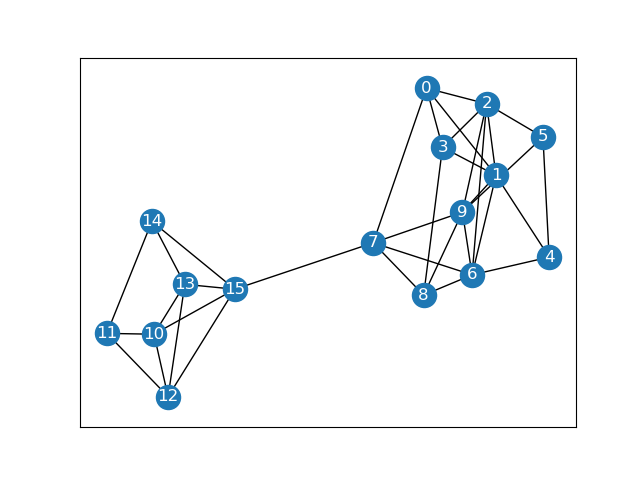

In [5]:
# expected result: picture.png
from IPython import display
display.Image("picture.png")

In [6]:
import csv
import pandas as pd
import networkx as nx
from typing import TextIO

def load_unweighted_network(node_csv:TextIO, edge_csv:TextIO) -> nx.classes.graph.Graph:
    df_node = pd.read_csv(node_csv)
    df_edge = pd.read_csv(edge_csv)

    network = nx.Graph()
    network.add_nodes_from(df_node["Id"].tolist())
    network.add_edges_from(list(zip(df_edge.Source, df_edge.Target)))

    # optionally add "Community" as node attribute
    # communities = df_node["Community"].tolist()
    # for id in network.nodes:
    #   network.nodes[id]["Community"] = communities[id]

    return network

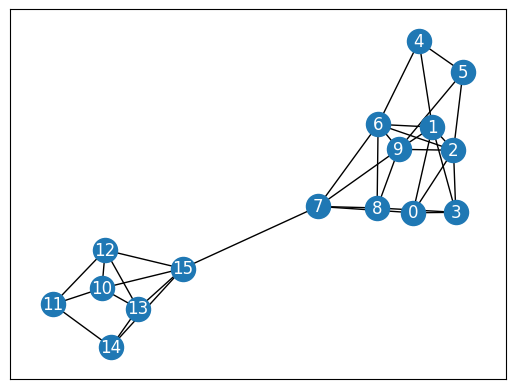

In [7]:
import matplotlib.pyplot as plt

def test_load():
    network = load_unweighted_network("toy-nodes.csv", "toy-edges.csv")
    nx.draw_networkx(network,font_color='white') #original
    plt.show()

test_load()

### 1.2  Modularité / Modularity

La modularité $Q$ du réseau est une mesure importante pour l'algorithme: elle permet de savoir si l'algorithme a atteint un optimum local. $$ Q=\frac{1}{2m}\sum_{u,v=1}^n B_{uv}\delta(l_u,l_v)$$

- m: le nombre d'arêtes
- l: l'étiquette du sommet
- u, v: des sommets dans le réseau
- B: la matrice de modularité où chaque élément vaut $A_{uv} - P_{uv}$
- $A_{uv}$: vaut 1 si il y une arête entre u et v sinon 0
- $P_{uv}$: la probabilité qu'il y ait une arête entre u et v selon le modèle nul  $$P_{uv}=\frac{degree(u)*degree(v)}{2m}$$
- $\delta(l_u,l_v)$: delta de Kronecker, vaut 1 si les deux labels sont identiques sinon 0

&nbsp;

#### Implémentation
La fonction  `modularity`  dans LPAmPlus retourne la modularité du réseau. La fonction `nx.linalg.modularity_matrix` de networkx calcule la matrice B.

**N.B:** Networkx permet d'ajouter du data sur les sommets pour garder des informations sur le node. Les nodes agissent comme des dictionnaires.

La fonction `test_modularity` vérifie l'implémentation de la fonction. Nous devrions obtenir une modularité d'environ 0.413.

&nbsp;

---
&nbsp;

The modularity $Q$ of the network is an important measure for the algorithm. The algorithm uses it to determine if it reached a local optimum. $$ Q=\frac{1}{2m}\sum_{u,v=1}^n B_{uv}\delta(l_u,l_v)$$

- m: number of edges
- l: node's label
- u, v: nodes in the graph
- B: modularity matrix where each element is $A_{uv} - P_{uv}$
- $A_{uv}$: is 1 if there is an edge between u and v else 0
- $P_{uv}$: probability that there is an edge between u and v following the null model $$P_{uv}=\frac{degree(u)*degree(v)}{2m}$$
- $\delta(l_u,l_v)$: Kronecker's delta, is 1 if the two labels are the same else 0

&nbsp;
#### Implementation
In the class LPAmPlus, the method `modularity` returns the modularity of the network. The function `nx.linalg.modularity_matrix` from networkx calculates B.

 **N.B:**  We can add data to nodes with Networkx to store information about the node. The nodes act like a dictionnary.

The function `test_modularity` tests the implementation. The expected modularity is 0.413.

In [8]:
def test_modularity():
    social_network = load_unweighted_network("toy-nodes.csv", "toy-edges.csv")
    lpam = LPAmPlus(social_network)
    lpam.labels = [0, 1]
    for i in [0,1,2,3,4,5,6,7,8,9]:
        lpam.graph.nodes[i]['label'] = 0
    for i in [10,11,12,13,14,15]:
        lpam.graph.nodes[i]['label'] = 1
    print("Modularity: {:.3f}".format(lpam.modularity()))

test_modularity()

Modularity: 0.413


### 1.3 Règle de modification des étiquettes / Updating rule for the labels

Comme mentionné plus haut, l'algorithme est fortement basé sur son optimisation de la modularité. Il vous est maintenant demandé d'implémenter le terme à optimiser. La nouvelle étiquette $l_x^{new}$ correspond à l'étiquette pour laquelle la somme donne la plus grande valeur.
$$l_x^{new}=\arg\max_l\sum_{u=1}^n B_{ux}\delta(l_u,l)$$

- n: le nombre de sommets
- m: le nombre d'arêtes
- l: une étiquette possible pour le sommet x
- x: le sommet qu'on évalue en ce moment
- u: un autre sommet dans le réseau (commence à 1, car on exclut le sommet x)
- B: la matrice de modularité où chaque élément vaut $A_{ux} - P_{ux}$
- $A_{ux}$: vaut 1 si il y une arête entre u et x sinon 0
- $P_{ux}$: la probabilité qu'il y ait une arête entre u et x selon le modèle nul  $$P_{ux}=\frac{degree(u)*degree(x)}{2m}$$
- $\delta(l_u,l)$: delta de Kronecker, vaut 1 si les deux labels sont identiques sinon 0


#### Implémentation
1. Implémenter la fonction `label_evaluation`. Cette fonction retourne la valeur du terme à optimiser. Vous pouvez utiliser la fonction `linalg.modularity_matrix` de networkx pour calculer la matrice B. Il est normal qu'il y ait une ressemblance avec le calcul de la modularité selon la définition que vous avez prise. `new_label` correspond donc à un $l$ possible dans le terme.
2. Implémenter la fonction `update_label`. Cette fonction choisit la nouvelle étiquette pour le sommet actuel. En cas d'égalité, la fonction choisit une étiquette au hasard parmi les meilleurs.

N'oubliez pas d'enlever les étiquettes désuètes du paramètre `labels`. **N.B:** Il est possible que la meilleure étiquette soit celle actuelle du sommet.

Networkx permet d'ajouter du data sur les sommets. Les sommets sont des dictionnaires dans le graphe.

---
&nbsp;

As mentioned above, the algorithm is strongly based on its optimization of modularity. We will implement the term to optimize. The new label $l_x^{new}$ corresponds to the label for which the sum gives the greatest value, which is the most frequent label among its neighbors.
$$l_x^{new}=\arg\max_l\sum_{u=1}^n B_{ux}\delta(l_u,l)$$
- n: number of nodes
- m: number of edges
- l: a possible label for the node x
- x: current node being evaluated
- u: another node in the network (starts at 1, because we exclude the node x)
- B: modularity matrix where each element is $A_{ux} - P_{ux}$
- $A_{ux}$: is 1 if there is an edge between u and x else 0
- $P_{ux}$: the probability that there is an edge between u and x  following the null model  $$P_{ux}=\frac{degree(u)*degree(x)}{2m}$$
- $\delta(l_u,l)$: Kronecker's delta, is 1 if labels are the same else 0


#### Implementation
1. The function `label_evaluation` returns the value for the term to optimize. We use the function `linalg.modularity_matrix` from networkx to calculate B. `new_label` represents a possible $l$ in the term.
2. The function `update_label` chooses the new label for the current node. If there is more than one label with the max value, the function chooses one randomly.

Don't forget to remove the unused labels from the `labels` attribute. **N.B:** The best label can be the node's current label.

You can add data to nodes with Networkx to store information about the node. The nodes act like a dictionnary.



### 1.4 LPAm

L'algorithme LPAm est le prédécesseur de LPAm+ puisque LPAm+ a été crée pour contourner une faiblesse de LPAm.  LPAm est un algorithme de propapagation d'étiquettes basé sur la modularité. Il commence par donner une étiquette unique à chaque sommet. Il explore par la suite tous les sommets et change leur étiquette selon la fonction d'évaluation. L'algorithme continue la propagation d'étiquette à travers tous les sommets jusqu'à un optimun de la modularité.

#### Implémentation
1. Ajouter les étiquettes initiales aux sommets du graphe dans la fonction `__init__`. Il faut que chaque sommet soit dans sa propre communauté au début de l'algorithme. Initialiser le paramètre `labels` pour qu'il contient la liste des étiquettes présentes dans le réseau.

2. Implémenter l'algorithme LPAm dans la fonction `LPAm`. Assurez-vous de toujours augmenter la modularité lors de vos changements d'étiquettes. Garder le paramètre `labels` à jour à fur et à mesure lors des changements pour ne pas évaluer plusieurs fois la même étiquette.

La fonction `test_lpam` vérifie l'implémentation. Il faut avoir une modularité d'environ 0.399 avec 4 communautés.

---

The LPAm algorithm is the predecessor of LPAm+ since LPAm+ was created to overcome LPAm's weakness. LPAm is a label probagation algorithm based on modularity. It begins by giving a unique label to each node. It then explores all the nodes and changes their label according to the evaluation function. The algorithm continues until it can no longer improve the modularity of the network.

#### Implementation
1. Add the initial labels to the nodes in the graph in the function `__init__`. Each nodes has to be in their own community in the beginning. Initialise `labels` with the current list of labels present in the graph.

2. Implement the LPAm algorithm in the function`LPAm`. Make sure that all labels changes improve the modularity. Keep `labels` parameter up-to-date so that we don't evaluate the same label multiple times or unused labels.

The function `test_lpam` verifies the implementation. Expect to have a modularity of 0.399 with 4 communities.

In [9]:
def test_lpam():
    social_network = load_unweighted_network("toy-nodes.csv", "toy-edges.csv")
    lpam = LPAmPlus(social_network)
    lpam.LPAm()
    print("Modularity: {:.3f}\nCommunities: {}".format(lpam.modularity(), lpam.labels))

test_lpam()

Modularity: 0.399
Communities: [3, 3, 3, 3, 5, 5, 8, 8, 8, 8, 11, 11, 11, 11, 11, 11]


### 1.5 LPAm+

Vous pouvez maintenant implémenter LPAm+ au complet. LPAm+ est une amélioration de LPAm. Lorsque LPAm tombe dans un optimum local, LPAm+ essaye de combiner deux communautés pour augmenter la modularité et ainsi sortir du optimum local. LPAm+ choisit la combinaison qui augmente le plus la modularité et recommence la propagation d'étiquette jusqu'au prochain optimum local où il va reessayer de combiner des communautés. L'algorithme continue jusqu'à qu'il ne peut plus augmenter la modularité.

#### Implémentation
1. Implémentez  la fonction  `merge_communities`. Cette fonction regarde si combiner des communautés augmente la modularité et combine le meilleur choix. Elle retourne True si une combinaison a été faite sinon False (aucune combinaison augmente la modularité).
2. Implémenter `find_communities`. Cette fonction applique l'algorithme LPAm+ sur le réseau en utilisant les fonctions `LPAm` et `merge_communities`.

La fonction `test_lpam_plus` vérifie l'implémentation. Il faut avoir une modularité d'environ 0.413 et 2 communautés.

---

We can now implement LPAm+, an enhancement of LPAm. The issue with LPAm is that it stops when it finds a local optimun. To overcome that, LPAm+ tries to combine two communities to increase modularity and escape the local optimun. LPAm+ chooses the combination that increases the modularity the most and restart the label's propagation until the next local optimum. Then it will try to combine two communities again. The algorithm continues until it can no longer increase modularity.

#### Implementation
1. Implement the method  `merge_communities`. This function checks if combining communities improve the modularity and combine the best choice. It returns True if a combinaison was made else False (no combination increases the modularity).
2. Implement the function `find_communities`. This function applies LPAm+ using functions `LPam` and `merge_communities`.

The function `test_lpam_plus` verifies the implementation. Expected result is a modularity of 0.413 and 2 communities.

In [10]:
def test_lpam_plus():
    social_network = load_unweighted_network("toy-nodes.csv", "toy-edges.csv")
    lpam = LPAmPlus(social_network)
    lpam.find_communities()
    print("Modularity: {:.3f}\nCommunities: {}".format(lpam.modularity(), lpam.labels))

test_lpam_plus()

Modularity: 0.413
Communities: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 11, 11, 11, 11, 11]


### 1.6 GOT dataset

Rouler l'algorithme sur les données de Games of Thrones de chaque saison et comparer ce que nous obtenons et les vraies communautés. Le ground truth se trouve dans la colonne Community des csv. Des liens sont présents entre des personnages lorsque:
- Personnage A parle directement après Personnage B
- Personnage A parle de Personnage B
- Personnage C parle de Personnage A et Personnage B
- Personnage A et Personnage B font une action ensemble dans une scène (ex: quittent les lieux, A regarde B, sont assis à une table, etc)
- Personnage A et Personnage B apparaissent ensemble dans une scène

Commencez par calculer le RI (Rand index). $$ RI=\frac{TP+TN}{TP+TN+FP+FN} = \frac{TP+TN}{\binom{n}{2}}$$

- n: le nombre de sommets
- TP: True positive soit le nombre de paires d'éléments qui se trouvent dans la même communauté dans nos résultats et dans le ground truth
- TN: True négative soit le nombre de paires d'éléments qui se trouvent dans des communautés différentes dans nos résultats et dans le ground truth
- FP: False positive soit le nombre de paires d'éléments qui se trouvent dans la même communauté dans nos résultats mais qui sont dans des communautés différentes dans le ground truth
- FN: False négative soit le nombre de paires d'éléments qui se trouvent dans des communautés différentes alors qu'ils sont dans la même communauté dans le ground truth


**N.B**: Ce n'est pas le nom des communautés que nous avons trouvé qui importante mais leur composition. Autrement dit, un TP est si le sommet a et le sommet b se trouve dans la même communauté dans nos résultats et dans le ground truth.

---

Run your algorithm over the Games of Thrones data from each season and compare what you get and the real communities. The ground truth is found in the Community column in the csv. Links are found between characters A and B when:
- Character A talks directly after Character B
- Character A talks about Character B
- Character C talks about Character B and A
- Character A and Character B does an action together in a scene (ex: leave the room, A looks toward B, are seated together at a table, etc)
- Character A and Character B are both present in a scene

Start by calculating the RI (Rand index) of your results. $$ RI=\frac{TP+TN}{TP+TN+FP+FN} = \frac{TP+TN}{\binom{n}{2}}$$

- n: number of nodes
- TP: True positive the number of pairs of elements that are in the same community in our results and in the ground truth
- TN: True negative the number of pairs of elements that are in different communities in our results and in the ground truth
- FP: False positive the number of pairs of elements which are in the same community in our results but which are in different communities in the ground truth
- FN: False negative the number of pairs of elements which are in different communities in our results but which are in the same community in the ground truth

**N.B:** What matters here is the composition of the communities, not the names of the communities. A TP is when node a and node b are both in the same communities in our result and in the ground truth.



#### Résultats / Results

In [11]:
# GOT dataset and LPAm+ performance evaluation

def get_community_size_gold(df_node):
    gold_communities = (df_node.Community.unique())
    num_per_comm_gold = {}
    for c in gold_communities:
        num_per_comm_gold[c] = len(df_node[df_node['Community'] == c]["Id"].to_list())

    sorted_num_per_comm_gold = sorted(num_per_comm_gold.items(), key=lambda x: x[1], reverse=True)

    return sorted_num_per_comm_gold


def get_community_size_pred(dcomm_pred):

    num_per_comm_pred = {}
    for k, v in dcomm_pred.items():
        if not num_per_comm_pred.get(v):
            num_per_comm_pred[v] = 1
        else:
            num_per_comm_pred[v] += 1
    sorted_num_per_comm_pred = sorted(num_per_comm_pred.items(), key=lambda x: x[1], reverse=True)

    return  sorted_num_per_comm_pred


def eval_community():

    tps = 0
    fns = 0
    tns = 0
    fps = 0

    # detect communities using LPAm+ (prediction)
    social_network = load_unweighted_network(file_nodes, file_edges)

    lpam = LPAmPlus(social_network)
    lpam.find_communities()
    # below: return a dict of attributes keyed by node (key=id, values=community)
    # the community originates from Id, indicates different groups. but the exact name will not be the same as in ground truch.
    dcomm_pred = nx.get_node_attributes(lpam.graph, 'label')
    sorted_num_per_comm_pred = get_community_size_pred(dcomm_pred)


    # prepare the ground truth
    df_node = pd.read_csv(file_nodes)
    gold_communities = (df_node.Community.unique())
    # dict (key=id, value=Community)
    dcomm_gold = dict(zip(df_node.Id, df_node.Community))
    # assume any two person have a link, maximum # of pairs
    pairs = list(itertools.combinations(df_node.Id, 2))
    sorted_num_per_comm_gold = get_community_size_gold(df_node)


    for p in pairs:
        # Person1 and person2 of pair p are in the same Community
        if (dcomm_gold[p[0]] == dcomm_gold[p[1]]) and (dcomm_pred[p[0]] == dcomm_pred[p[1]]):
            tps += 1
        elif (dcomm_gold[p[0]] == dcomm_gold[p[1]]) and (dcomm_pred[p[0]] != dcomm_pred[p[1]]):
            fns += 1
        elif (dcomm_gold[p[0]] != dcomm_gold[p[1]]) and (dcomm_pred[p[0]] != dcomm_pred[p[1]]):
            tns += 1
        elif (dcomm_gold[p[0]] != dcomm_gold[p[1]]) and (dcomm_pred[p[0]] == dcomm_pred[p[1]]):
            fps += 1
        else:
            pass

    total = tps + fns + tns + fps
    RI = (tps + tns) / total
    Q = lpam.modularity()
    # number of community- predicted
    NC_pred = len(set(lpam.labels))
    # number of community- ground truth
    NC_gold = len(gold_communities)

    print("total pairs: ", len(pairs), "\ntotal pairs evaluated: ", total)
    print("RI: {:.3f}".format(RI))
    print("Modularity: {:.3f}".format(Q))
    print("Number of Ground truth Communities: {}".format(NC_gold))
    print("Number of Predicted Communities: {}".format(NC_pred))
    print("\n")
    print("Predicted Community_size: ", [x[1] for x in sorted_num_per_comm_pred])
    print("Ground truth Community_size: ", [x[1] for x in sorted_num_per_comm_gold])

    return (RI, Q, NC_pred, NC_gold, total)


### main

result = dict(season=[], RI=[], Q=[], NC_pred=[], NC_gold=[], All_pairs=[])

for i in range(1,9):
    file_nodes = "got-s" + str(i) + "-nodes.csv"
    file_edges = "got-s" + str(i) + "-edges.csv"
    print("season: ", i, "\t", file_nodes, file_edges)
    (RI, Q, NC_pred, NC_gold, total) = eval_community()
    result["season"].append(i)
    result["RI"].append(RI)
    result["Q"].append(Q)
    result["NC_pred"].append(NC_pred)
    result["NC_gold"].append(NC_gold)
    result["All_pairs"].append(total)
    print("\n")

df_result = pd.DataFrame.from_dict(result)



season:  1 	 got-s1-nodes.csv got-s1-edges.csv
total pairs:  7875 
total pairs evaluated:  7875
RI: 0.904
Modularity: 0.451
Number of Ground truth Communities: 7
Number of Predicted Communities: 6


Predicted Community_size:  [47, 38, 18, 17, 4, 2]
Ground truth Community_size:  [44, 23, 19, 17, 17, 4, 2]


season:  2 	 got-s2-nodes.csv got-s2-edges.csv
total pairs:  8256 
total pairs evaluated:  8256
RI: 0.969
Modularity: 0.569
Number of Ground truth Communities: 7
Number of Predicted Communities: 6


Predicted Community_size:  [34, 29, 20, 18, 14, 14]
Ground truth Community_size:  [32, 31, 20, 17, 14, 14, 1]


season:  3 	 got-s3-nodes.csv got-s3-edges.csv
total pairs:  7503 
total pairs evaluated:  7503
RI: 0.926
Modularity: 0.627
Number of Ground truth Communities: 9
Number of Predicted Communities: 5


Predicted Community_size:  [30, 29, 28, 24, 12]
Ground truth Community_size:  [28, 23, 17, 14, 12, 8, 7, 7, 7]


season:  4 	 got-s4-nodes.csv got-s4-edges.csv
total pairs:  14535 
t

In [12]:
df_result

,season,RI,Q,NC_pred,NC_gold,All_pairs
0,1,0.904127,0.451463,6,7,7875
1,2,0.968871,0.568782,6,7,8256
2,3,0.925630,0.626897,5,9,7503
3,4,0.924252,0.603035,8,9,14535
4,5,0.980772,0.670117,6,6,7021
5,6,0.940166,0.648542,8,9,10011
6,7,0.876852,0.318035,4,4,3240
7,8,0.487967,0.201346,5,5,2701


<Axes: xlabel='season'>

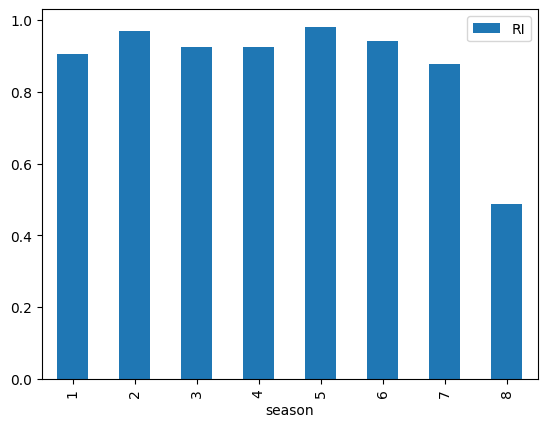

In [13]:
df_result.plot(kind='bar', x = 'season', y= 'RI')

#### Analyse / Analysis

- L'algorithme performe-t-il bien sur toutes les saisons ou pour certaines seulement?
- Does the algorithm perform well on all seasons or for some only?

> The algorithm performs well for seasons 1-6, RI > 0.90; it performs reasonably well for season 7 with a RI (0.80, 0.90); it performs badly for season 8 with a RI < 0.55.

- Expliquez pourquoi nous avons obtenu ces résultats en analysant la formation des communautés dans chaque saison. Quelles particularités favorisent des bons résultats? Quelles particularités nuisent à l'algorithme?
- Explain why we obtained these results by analysing the communities from each season. Which particularities offer better results? Which hinder the algorithm?

> The clustering algorithm may give different results each time we run it. But, it always performs well (hight RI) when the network has a larger Modularity value Q. Q is a measure of how well a network is partitioned into communities. We consider a network has significant community structure when Q > 0.7. In our cases, when Q = [0.5, 0.7], the algorithm performs very well.

> For the seasons it performs well, the algorithem tends to form larger groups than the "ground truth". This is to say, it detects less number of communities.


> Season 8 has less number of personalities/nodes, but they are more connected than previous seasons (actual connections / total possible connections: 554 /2701). This means most of the 74 nodes could belong one single community, which is true since the groud truth says: 56 persons are in communite 1. However, the algorithm splits them to 3 communites.



# 2. Personnages influents dans GOT / Influent character in GOT

##  Analyse d'un réseau social
Une autre analyse intéressante à faire avec un réseau social est de trouver les personnes influentes du réseau soit les personnes autour desquelles les gens du réseau se regroupent.

Il existe des mesures qui permettent de connaître ces personnes: les mesures de centralité. **Nous allons implémenter les mesures nous-même au lieu d'utiliser les implémentations de `networkx` de ces mesures.** Pour nous aider lors de l'implémentation de ses mesures, nous utiliserons la deuxième toy dataset. Il ressemble à ceci (data/picture2.png):
![title](picture2.png)

## GOT datasets
La série Games of Thrones est reconnue pour tuer ses personnages importants. Nous allons vérifier cette affirmation. Nous utiliserons tous les CSV (nodes, edges et deaths). Nous voulons trouver les personnages les plus influents de chaque saison et les comparer avec la liste de personnages morts durant la saison.

---

##  Social network analysis

Another interesting analysis to do with a social network is to find the influential people in the network, i.e., the person around whom people in the network gather.

There are measures that make it possible to know these people: the centrality measures. **We will implement those metrics ourselves rather than using `networkx` implementation.** During the implementation, we will use a second toy dataset. It looks like this (data/picture2.png): ![title](data/picture2.png)

## GOT datasets
The Games of Thrones series is known to kill its important characters. We will verify this statement. We will use all the csv (nodes, edges and deaths). We want to find the most influential characters from each season and compare them with the list of dead characters during the season.


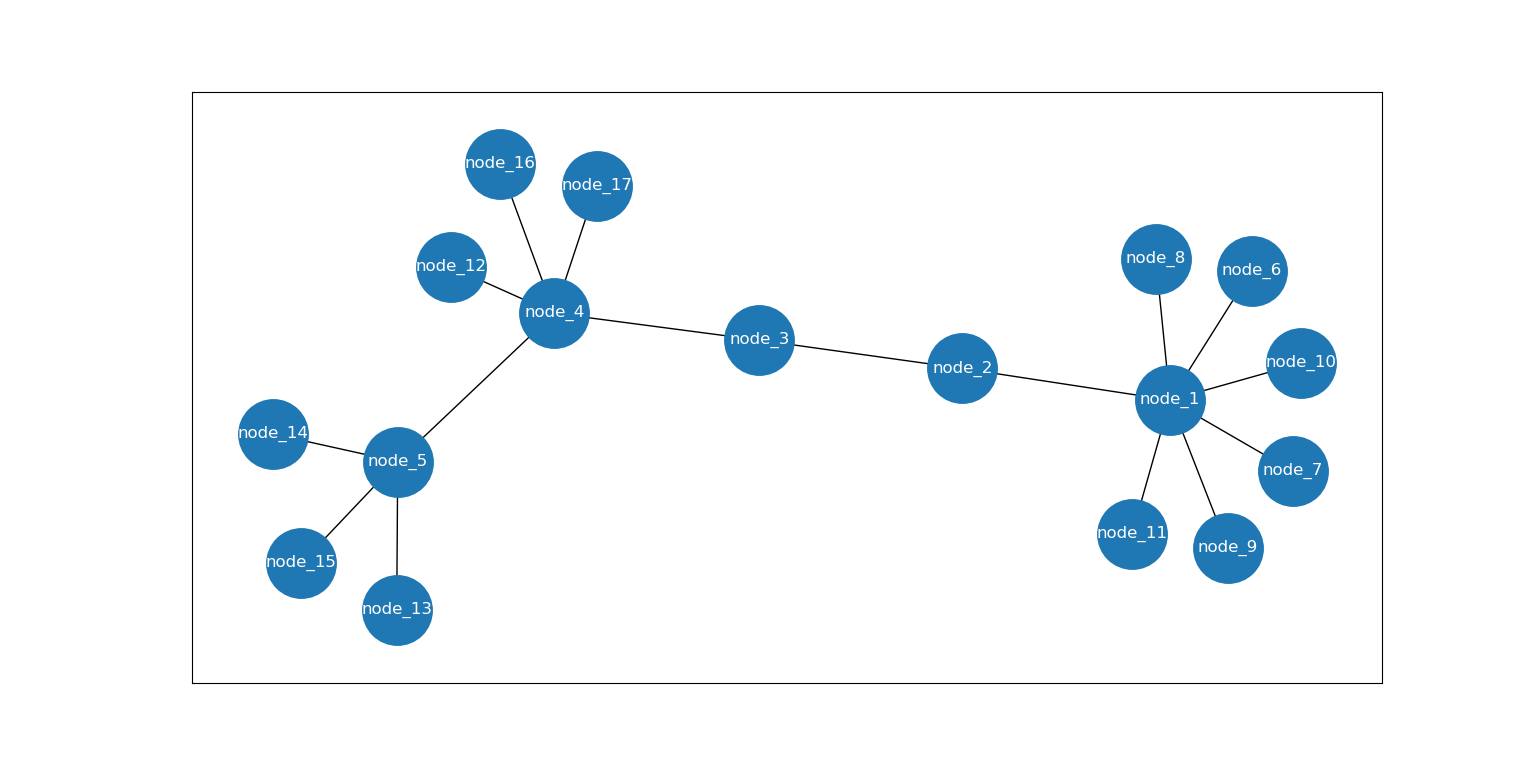

In [93]:
# expected result: picture.png
from IPython import display
display.Image("picture2.png")

## 2.1 Centralité de degré / Degree centrality

Une première mesure simple pour trouver l'importance d'un sommet dans un réseau est la centralité de degré. Elle se calcule $$C_{D}(i) = \frac{degree(i)}{n-1}$$

- i: un sommet dans le réseau
- n: le nombre de sommets
- degree: le nombre d'arêtes attachées au sommet

#### Implémentation
1. La fonction `calculate_degree_centrality` calcule la centralité de degré pour tous les sommets du réseau et ajoute cette mesure à chaque sommet.

La fonction `test_degree_centrality` vérifie notre implémentation. Le sommet 1 devrait avoir la plus haute mesure de 0.4.

---

A first simple measure to find the importance of a node in a network is the degree centrality. It is calculated $$C_{D}(i) = \frac{degree(i)}{n-1}$$

- i: a node in the network
- n: the number of nodes
- degree: the number of edges attached to the node

#### Implementation
1. The function `calculate_degree_centrality` calculates degree centrality for all nodes in the network and adds this measurement to each node.

The function `test_degree_centrality` verifies our implementation. The best node should be node 1 with 0.4.

In [16]:
def calculate_degree_centrality(social_network):
    dict_degree = {}
    N = nx.number_of_nodes(social_network)
    for node in social_network.nodes:
        degree = len(social_network.edges(node))
        Cd = degree / (N - 1)
        dict_degree[node] = {"degree_centrality": Cd}
    # add the measure to each node
    nx.set_node_attributes(social_network, dict_degree)
    return 0

In [17]:
def test_degree_centrality():
    social_network = load_unweighted_network("toy-nodes.csv", "toy-edges.csv")
    calculate_degree_centrality(social_network)
    dict_centrality = nx.get_node_attributes(social_network, 'degree_centrality')
    best_node = max(dict_centrality, key=dict_centrality.get)
    print("Highest degree centrality node: {} with {:.3f}".format(best_node, dict_centrality[best_node]))
test_degree_centrality()

Highest degree centrality node: 1 with 0.400


## 2.2 Centralité de proximité / Closeness centrality

Une autre mesure simple pour trouver l'importance d'un sommet dans un réseau est la centralité de proximité. Elle se calcule $$C_{P}(i) = \frac{1}{AvDist(i)}$$

- i: un sommet dans le réseau
- AvDist: la moyenne de toutes les distances les plus courtes pour atteindre chaque sommet à partir du sommet i

#### Implémentation
1. La fonction `calculate_closeness_centrality` calcule la centralité de proximité pour tous les sommets du réseau et ajoute cette mesure à chaque sommet. Considérer chaque arête comme une distance de 1.

**NB**: La fonction `shortest_path()` du module Networkx est pour trouver le chemin le plus court entre des sommets

La fonction `test_closeness_centrality` vérifie notre implémentation. Le sommet 7 devrait avoir la plus haute mesure de 0.577.

---

Another simple measure for finding the importance of a node in a network is closeness centrality. It is calculated $$C_{P}(i) = \frac{1}{AvDist(i)}$$

- i: a node in the network
- AvDist: the average of all shortest distances to reach each vertex from vertex i

#### Implementation
1. The function `calculate_closeness_centrality` calculates closeness centrality for all nodes in the network and adds this measurement to each node. Consider each edge as a distance of 1.

**NB**: The fucntion `shortest_path()` from Networkx finds the shortest path between two nodes.

The function `test_closeness_centrality` verifies your implementation. The best node should be node 7 with 0.577.

In [22]:
def calculate_closeness_centrality(social_network):
    dict_closeness = {}
    N = nx.number_of_nodes(social_network)
    for src in social_network.nodes:
        total_dist = 0
        for tgt in social_network.nodes:
            dist = nx.shortest_path(social_network, source=src, target=tgt)
            total_dist += len(dist) -1
        av_dist = total_dist / (N - 1)
        Cp = 1 / av_dist
        dict_closeness[src] = {"closeness_centrality": Cp}
    # add measure as node attribute
    nx.set_node_attributes(social_network, dict_closeness)
    return 0

In [23]:
def test_closeness_centrality():
    social_network = load_unweighted_network("toy-nodes.csv", "toy-edges.csv")
    calculate_closeness_centrality(social_network)
    dict_centrality = nx.get_node_attributes(social_network, 'closeness_centrality')
    best_node = max(dict_centrality, key=dict_centrality.get)
    print("Highest closeness centrality node: {} with {:.3f}".format(best_node, dict_centrality[best_node]))

test_closeness_centrality()

Highest closeness centrality node: 7 with 0.577


## 2.3 Centralité d'intermédiarité / Betweeness centrality

Une dernière mesure simple pour trouver l'importance d'un sommet dans un réseau est la centralité d'intermédiarité. Elle se calcule $$C_{I}(i) = \frac{\sum_{j<k}f_{jk}(i)}{\binom{n}{2}}$$

- n: le nombre de sommets dans le réseau
- i: un sommet dans le réseau
- j,k: deux sommets dans le réseau excluant i
- $f_{jk}(i)$: le nombre de chemin le plus court partant du sommet j vers un sommet k (> j) passant par le sommet i

#### Implémentation
1. La fonction `calculate_betweenness_centrality` calcule la centralité d'intermédiarité pour tous les sommets du réseau et ajoute cette mesure à chaque sommet.

La fonction `test_betweennes_centrality` vérifie notre implémentation. Le sommet 7 devrait avoir la plus haute mesure de 0.45.

---

A final simple measure to find the importance of a node in a network is the betweeness centrality. It is calculated $$C_{I}(i) = \frac{\sum_{j<k}f_{jk}(i)}{\binom{n}{2}}$$

- n: the number of nodes in the network
- i: a node in the network
- j,k: two nodes in the network excluding i
- $f_{jk}(i)$: the  number of shortest paths from vertex j to vertex k (> j) passing through node i

#### Implementation
1. The function `calculate_betweenness_centrality` calculates the betweenness centrality for all the nodes of the network and adds this measurement to each node.

The function `test_betweennes_centrality` verifies our implementation. The best node should be the node 7 with 0.525.


In [24]:
def calculate_betweenness_centrality(social_network):
    dict_betweenness = {}
    N = nx.number_of_nodes(social_network)
    node_lst = list(social_network.nodes)
    for i in social_network.nodes:
        Mf = np.zeros((N, N))
        for j in range(N):
            for k in range(j+1, N):
                if j != i and k != i:
                    paths = nx.all_shortest_paths(social_network, source=node_lst[j], target=node_lst[k])
                    cnt = 0
                    num_p_i = 0
                    for path in paths:
                        cnt += 1
                        num_p_i = (num_p_i+1) if i in path else 0
                    Mf[j, k] = num_p_i/cnt
        total_f = np.sum(Mf)
        n = N - 1
        bino_coef = n * (n -1) / 2
        CI = total_f / bino_coef
        dict_betweenness[i] = {"betweenness_centrality": CI}
    nx.set_node_attributes(social_network, dict_betweenness)
    return 0

In [27]:
def test_betweenness_centrality():
    social_network = load_unweighted_network("toy-nodes.csv", "toy-edges.csv")
    calculate_betweenness_centrality(social_network)
    dict_centrality = nx.get_node_attributes(social_network, 'betweenness_centrality')
    best_node = max(dict_centrality, key=dict_centrality.get)
    print("Highest betweenness centrality node: {} with {:.3f}".format(best_node, dict_centrality[best_node]))

test_betweenness_centrality()

Highest betweenness centrality node: 7 with 0.525


## 2.4 Analyse les résultats / Analysis of the results

Nous allons executer les trois fonctions sur les réseaux de chaque saison et présenter le top 10 pour chaque mesure. **Les graphes des saisons 2, 4 et 6 sont déconnectés. Dans ce cas, considérons la plus grande composante connexe**. Pour chaque saison, nous voulons comparer le top 10 des mesures avec la liste de morts de la saison disponible dans les csv death.


---

We will present the top 10 most influential persons of each season for each of the three metrics with the help of the three functions. **The season 2, 4 and 6 graphs are disconnected. In that case, we will consider the largest connected component**. Then, For each season, compare the top 10 metrics with the season's death list in the death csv.



### Résultats / Results

In [110]:
# Le code pour présenter les résultats ici

def largest_component(graph):
    """
    find the largest connected component in a networkx graph
    return the largest subgraph
    """

    components = [graph.subgraph(c).copy() for c in nx.connected_components(graph)]

    if (len(list(enumerate(components,start=1)))) > 1:
        component_g_dict = {}
        component_size_dict = {}
        print("network is disconnected.")
        for idx, g in enumerate(components,start=1):
            #print(f"Component {idx}: Nodes: {nx.number_of_nodes(g)} \tEdges: {nx.number_of_edges(g)}")
            component_size_dict[idx] = nx.number_of_nodes(g)
            component_g_dict[idx] = g

        largest = max(component_size_dict, key=lambda key: component_size_dict[key])
        #print("largest component: ", largest)
        selected = component_g_dict[largest]

    else:
        print("network is connected.")
        selected = graph

    return selected


def analyse_death(season, measure):
    """
    Input the season (1,2,3...) and measure: list of tuples e.g., [(node, value), (...), ...]
    return ratio of (influential people / death), common names between influential people and the death
    """

    # prepare the name of those real death. ground truth.
    file_death = "got-s" + str(season) + "-deaths.csv"
    df_node = pd.read_csv(file_death)
    deaths = df_node.Id.to_list()

    # get the name of the top 10 most influent persons
    measure_id = [x[0] for x in measure]

    # the number of names in both
    common = set(measure_id).intersection(set(deaths))
    # % of influential people that dead.
    rate_measure = len(common)/len(deaths)

    return (rate_measure, common)


## main
# result contains the (predicted vs ground truth) for all seasons.
result = {}

for i in range(1,9):
    file_nodes = "got-s" + str(i) + "-nodes.csv"
    file_edges = "got-s" + str(i) + "-edges.csv"
    print("\nseason: ", i, "\t", file_nodes, file_edges)

    social_network = load_unweighted_network(file_nodes, file_edges)

    largest_subnetwork = largest_component(social_network)
    print("selected component has {} nodes.".format(nx.number_of_nodes(largest_subnetwork)))

    calculate_degree_centrality(largest_subnetwork)
    dict_degree = nx.get_node_attributes(largest_subnetwork, 'degree_centrality') # dict, key=node, value=centrality
    # sort by dict.values. result is a list of tuples. [(node, centrality), (...), (...)]
    top10_degree = sorted(dict_degree.items(), key=lambda x: x[1], reverse=True)[0:10]

    calculate_closeness_centrality(largest_subnetwork)
    dict_closeness = nx.get_node_attributes(largest_subnetwork, 'closeness_centrality')
    top10_closeness = sorted(dict_closeness.items(), key=lambda x: x[1], reverse=True)[0:10]

    calculate_betweenness_centrality(largest_subnetwork)
    dict_betweenness = nx.get_node_attributes(largest_subnetwork, 'betweenness_centrality')
    top10_betweenness = sorted(dict_betweenness.items(), key=lambda x: x[1], reverse=True)[0:10]

    # analyse result
    print("Analyse predicted vs ground truth-  influential persons vs death")
    result[i] = []
    measure_dict = {"top10_degree":top10_degree, "top10_closeness":top10_closeness, "top10_betweenness":top10_betweenness}
    print(pd.DataFrame.from_dict(measure_dict))

    for k, measures in measure_dict.items():
        (ratio, common) = analyse_death(i, measures)
        result[i].append((k, ratio, common))
    print(pd.DataFrame(result[i], columns=["measure", "ratio influential/death", 'common names']))



season:  1 	 got-s1-nodes.csv got-s1-edges.csv
network is connected.
selected component has 126 nodes.
Analyse predicted vs ground truth-  influential persons vs death
            top10_degree                top10_closeness  \
0           (NED, 0.456)      (NED, 0.6281407035175879)   
1        (TYRION, 0.328)   (ROBERT, 0.5530973451327433)   
2       (CATELYN, 0.288)  (CATELYN, 0.5506607929515418)   
3        (ROBERT, 0.288)   (TYRION, 0.5434782608695652)   
4           (ROBB, 0.24)      (JON, 0.5186721991701245)   
5        (CERSEI, 0.232)     (ROBB, 0.5122950819672131)   
6          (ARYA, 0.224)  (JOFFREY, 0.5102040816326531)   
7       (JOFFREY, 0.216)    (CERSEI, 0.508130081300813)   
8           (JON, 0.208)     (ARYA, 0.5020080321285141)   
9  (LITTLEFINGER, 0.208)   (JAIME, 0.49800796812749004)   

                 top10_betweenness  
0        (NED, 0.1991947282186029)  
1    (TYRION, 0.12314683306804843)  
2   (CATELYN, 0.08064979622085716)  
3    (ROBERT, 0.07224152051580318

### Analyse / Analysis




- Est-ce que le top 10 est suffisant pour trouver les morts importants de chaque saison?
- Is the top 10 enough to find the significant deaths of each season?

> The top 10 is enough to find the significant deaths except for season 2 and 8.


> The final result (above) is a dictionary. Key: season. For each season, there are 3 tuples. They are related to the measures degree, closeness and betweenness.
For each tuple, the first element is the % of names that appears in the death list, the second element contains those **names**.

> Compare the **names** in the result and the significant death (ref: google search). The following names are "important death":
S1:Robert, Ned; S2:(); S3:Robb, Catelyn; S4:Joffrey, Tywin; S5:Jon; S6:Ramsay,Margaery; S7:Olenna; S8:()


> Conclusion, even though the **names** in the result is only a small percentage of the number of deaths of each season (< 10%), they do represent the significant ones.

- Quelle mesure semble mieux prédire les morts?
- What measure seems to better predict the dead?

> No measure stands out. But betweenness seems better.
> the average prediction rate: (No. of death predicted / deaths)
* degree: 0.48662180319282183/8
* closeness: 0.4727767529776138/8
* betweenness: 0.6565826330532213/8

- Est-ce que la réputation de Games of Thrones de tuer plusieurs de ses personnages importants est fondée?
- Is the reputation of Games of Thrones for killing many important characters founded?


> I didn't watch it myself. But it seems true to me based on the analysis.


- Ref:
Google search of important deaths:
https://www.eonline.com/ca/news/1036935/game-of-thrones-25-most-important-deaths-so-far

